# Regression modeling 

In [2]:
import warnings
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from yellowbrick.regressor import residuals_plot, ResidualsPlot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
import json
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline


# Minimal Features Dataset
    * ElasticNet
    * SVM
    * RandomForest
    * AdaBoost
    * Multilayer Perceptron

In [3]:
df_min = pd.read_csv("../data/dataset_minimal_features_for_modeling.csv")
print(df_min.shape)
df_min.head(n=2)


(83658, 40)


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part^2,Rla_Pct_Part,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0,Grad_Rate,Ncessch,Year,Schnam,Stnam
0,1,0,221.627990,1170.0,9506.25,97.5,12.263999,0.438000,9506.25,0.064921,...,1,0,0,1,0,52.0,20000100208,2012,Bethel Regional High School,ALASKA
1,0,1,8.714286,1080.0,8100.00,90.0,0.000000,0.142857,8100.00,0.065574,...,0,0,1,1,0,10.0,20000100318,2012,Bethel Alternative Boarding School,ALASKA


In [4]:
# Split data into test & train
y = df_min.pop('Grad_Rate')
X = df_min
X.drop(["Ncessch", "Year", "Schnam", "Stnam"], axis=1, inplace=True)

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)


In [5]:
X.dtypes


School_Type_1.0                         int64
School_Type_4.0                         int64
Enrollment Teacher_Ratio2             float64
Highest_Grade_Offered Rla_Pct_Part    float64
Rla_Pct_Part^2                        float64
Rla_Pct_Part                          float64
Reduced_Price_Lunch Teacher_Ratio2    float64
Teacher_Ratio2                        float64
Math_Pct_Part Rla_Pct_Part            float64
Teacher_Ratio1                        float64
Free_Lunch                            float64
Civilian_Labor_Force                  float64
All_Cohort                              int64
Enrollment                            float64
Free_Or_Reduced_Price_Lunch           float64
Teachers_Fte                          float64
Reduced_Price_Lunch                   float64
Math_Pct_Part                         float64
Unemployment_Rate                     float64
Title_I_Status_5.0                      int64
Charter_0.0                             int64
Lowest_Grade_Offered              

In [6]:
def display_grid_results(results):
    """ Print out the GridSearchCV results """
    print(f'Best parameters are: {results.best_params_}')
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean, std, params in zip(mean_score, std_score, params):
        print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')


In [7]:
def append_to_model_params_log(string_id, obj):
    """ Save data as json to the model_best_parameters log file"""
    json.dump(string_id, open(
        "../logs/model_best_parameters.json", mode='a'))
    json.dump(obj, open(
        "../logs/model_best_parameters.json", mode='a'))


## ElasticNet (Generalized Linear Model)

In [8]:
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                       variables=Xtrain.columns.to_list())
min_max_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
                                           variables=Xtrain.columns.to_list())

pipe_elastic = Pipeline(steps=[("scale", std_scaler),
                               ("general_linear",
                               ElasticNetCV(
                                l1_ratio=[0.1, 0.4, 0.7, 1.0],
                                random_state=42,
                                max_iter=2000,
                                n_jobs=4,
                                cv=10))
                               ])


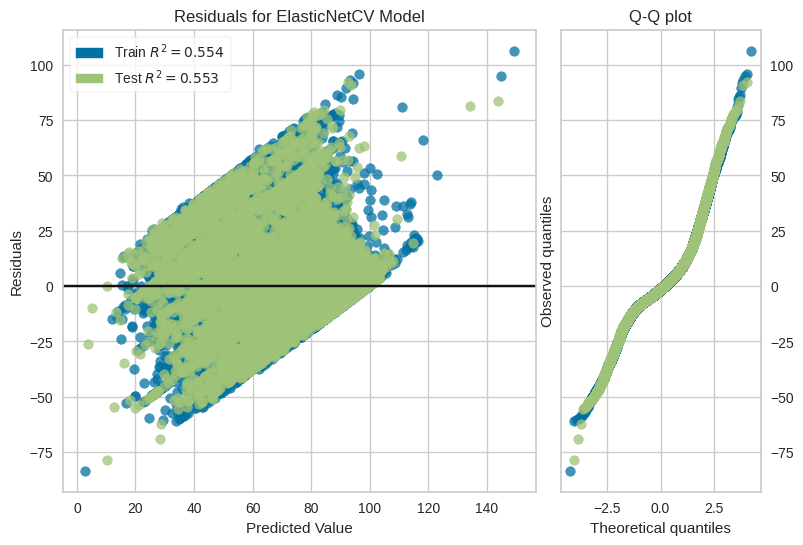

RMSE 12.994482654980393


In [9]:
def make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe):
    grid_results = pipe.fit(Xtrain, ytrain)
    plt.rcParams['figure.figsize'] = (9, 6)
    visualizer = ResidualsPlot(pipe, hist=False, qqplot=True)
    visualizer.fit(Xtrain, ytrain)
    visualizer.score(Xtest, ytest)
    visualizer.show()
    print("RMSE", mean_squared_error(
        ytest, visualizer.estimator.predict(Xtest), squared=False))
    return grid_results


elastic_grid_results = make_residual_plot_and_print_rmse(
    Xtrain, ytrain, Xtest, ytest, pipe_elastic)


# Support Vector Machine (SVR)

In [10]:
pipe_svm = Pipeline(steps=[("scale", std_scaler), ("svr", SVR())])

param_grid = {
    "svr__epsilon": [0.2, 0.4, 0.6],
    "svr__C": [3, 5, 7],
    "svr__kernel": ["rbf"],
}


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_svr_gridsearch2.pkl"
)
clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_svm,
        param_grid,
        n_jobs=6,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features", clf.best_params_)


In [11]:
print(clf.best_params_)
display_grid_results(clf)


{'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
Best parameters are: {'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.64 + or -0.01 for the {'svr__C': 3, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.65 + or -0.01 for the {'svr__C': 5, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.2, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.4, 'svr__kernel': 'rbf'}
0.66 + or -0.01 for the {'svr__C': 7, 'svr__epsilon': 0.6, 'svr__kernel': 'rbf'}


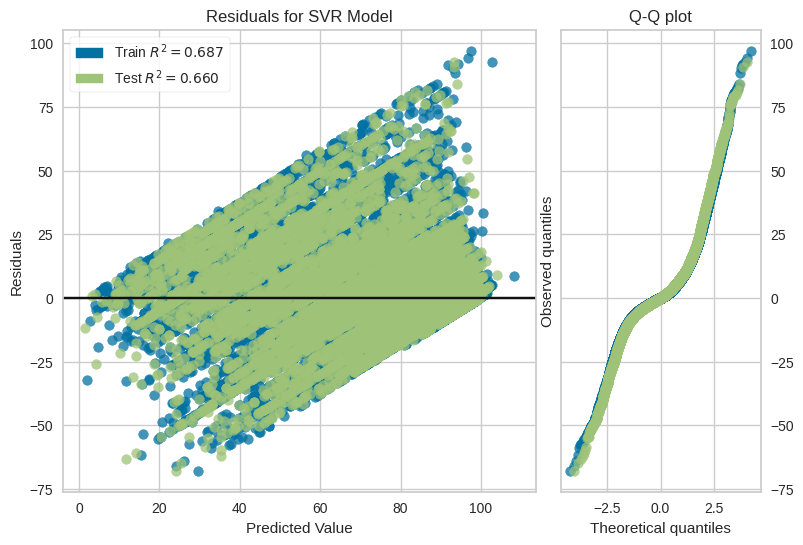

RMSE 11.335941455829168


Pipeline(steps=[('scale',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['School_Type_1.0',
                                                      'School_Type_4.0',
                                                      'Enrollment '
                                                      'Teacher_Ratio2',
                                                      'Highest_Grade_Offered '
                                                      'Rla_Pct_Part',
                                                      'Rla_Pct_Part^2',
                                                      'Rla_Pct_Part',
                                                      'Reduced_Price_Lunch '
                                                      'Teacher_Ratio2',
                                                      'Teacher_Ratio2',
                                                      'Math_Pct_Part '
                                                      'Rla_Pct_Part',
                                                      'Teacher_Ratio1',
                                                      'Free_Lunch',
                                                      'Civilian...
                                                      'Free_Or_Reduced_Price_Lunch',
                                                      'Teachers_Fte',
                                                      'Reduced_Price_Lunch',
                                                      'Math_Pct_Part',
                                                      'Unemployment_Rate',
                                                      'Title_I_Status_5.0',
                                                      'Charter_0.0',
                                                      'Lowest_Grade_Offered',
                                                      'Urban_Centric_Locale_11.0',
                                                      'Num_Grades',
                                                      'Virtual_1.0',
                                                      'Metro_Or_Not_0.0',
                                                      'Rural_Urban_Continuum_Code_1.0',
                                                      'Urban_Influence_Code_1.0',
                                                      'Title_I_Eligible_1.0',
                                                      'Title_I_Status_6.0', ...])),
                ('svr', SVR(C=7, epsilon=0.6))])

In [12]:
pipe_svm = Pipeline(steps=[("scale", std_scaler),
                    ("svr", SVR(C=7, epsilon=0.6, kernel="rbf"))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_svm)


# Multilayer Perceptron 

In [13]:
pipe_mlpr = Pipeline(steps=[("scale", std_scaler),
                     ("mlpr", MLPRegressor(max_iter=400))])

param_grid = {"mlpr__hidden_layer_sizes": [(50,), (100,)], "mlpr__activation": [
    "logistic", "tanh", "relu"], "mlpr__solver": ["sgd", "adam"], "mlpr__alpha": [0.0001, 0.0002]}

local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_mlpr_gridsearch1.pkl"
)
clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_mlpr,
        param_grid,
        n_jobs=5,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features", clf.best_params_)


In [14]:
display_grid_results(clf)


Best parameters are: {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'sgd'}
0.69 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'sgd'}
0.67 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'adam'}
0.7 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'sgd'}
0.68 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0001, 'mlpr__hidden_layer_sizes': (100,), 'mlpr__solver': 'adam'}
0.69 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0002, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'sgd'}
0.67 + or -0.01 for the {'mlpr__activation': 'logistic', 'mlpr__alpha': 0.0002, 'mlpr__hidden_layer_sizes': (50,), 'mlpr__solver': 'adam'}
0.7 + or -0.01 for the {'mlpr__a

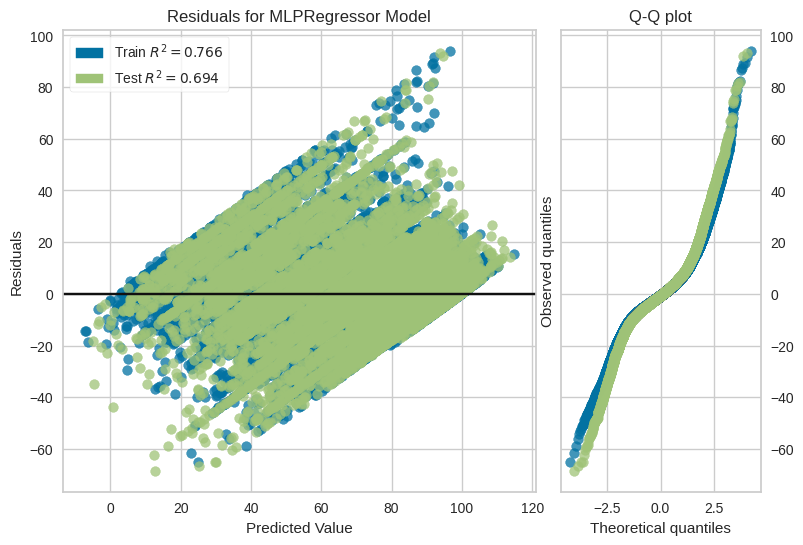

RMSE 10.748302837507039


['../model_files/deployment_model_mlpr']

In [15]:
pipe_mlpr = Pipeline(steps=[("scale", std_scaler),
                            ("mlpr", MLPRegressor(activation='logistic', alpha=0.0002, hidden_layer_sizes=(100,), solver='sgd', max_iter=1000, random_state=42))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_mlpr)
# Save our best model for deployment
pipe_mlpr.fit(Xtrain,ytrain)
joblib.dump(pipe_mlpr,"../model_files/deployment_model_mlpr")


# Adaboost

In [16]:
pipe_adar = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42))

param_grid = {'n_estimators': [800],
              'base_estimator__max_features': [0.3,0.9],
               'base_estimator__max_depth': [9,11],
              'learning_rate': [0.1,0.2],
              'loss': ['exponential']}


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_adar_gridsearch2.pkl"
)

clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_adar,
        param_grid,
        n_jobs=5,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features - AdaBoostRegressor", clf.best_params_)


In [17]:
display_grid_results(clf)

Best parameters are: {'base_estimator__max_depth': 11, 'base_estimator__max_features': 0.9, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.55 + or -0.01 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.3, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.48 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.3, 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 800}
0.58 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.9, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.52 + or -0.02 for the {'base_estimator__max_depth': 9, 'base_estimator__max_features': 0.9, 'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 800}
0.68 + or -0.01 for the {'base_estimator__max_depth': 11, 'base_estimator__max_features': 0.3, 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 800}
0.66 + or -0.01 for the {'base_estimator_

/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


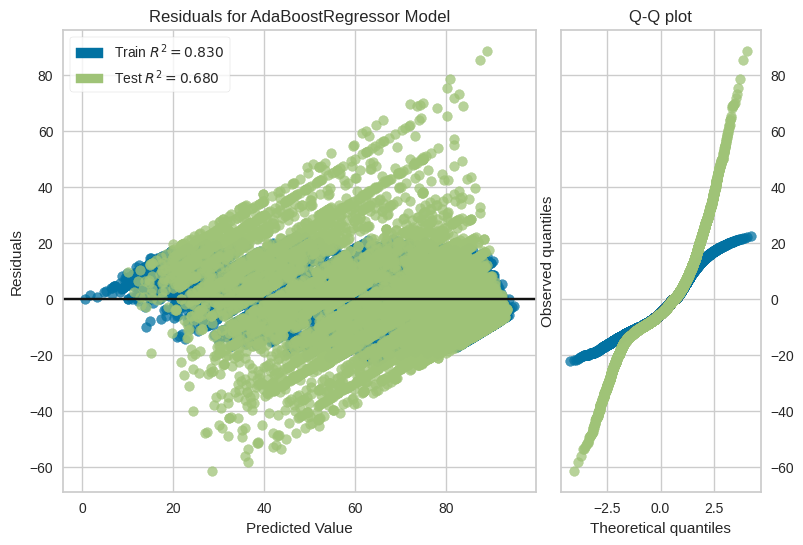

RMSE 10.999042839976715


Pipeline(steps=[('ada',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                                        max_features=0.9,
                                                                        random_state=42),
                                   learning_rate=0.1, loss='exponential',
                                   n_estimators=800))])

In [18]:
pipe_adar = Pipeline(steps=[("ada", AdaBoostRegressor(learning_rate=0.1, loss='exponential',n_estimators=800, base_estimator=DecisionTreeRegressor(max_features=0.9, max_depth=11, random_state=42)))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_adar)

# Random Forest

In [19]:
pipe_rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': [500,1000],
              'max_features': [0.1,0.3,0.8],
               'max_depth': [11,12,13],
              }


local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_rf_gridsearch1.pkl"
)

clf = {}
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_rf,
        param_grid,
        n_jobs=10,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)
    append_to_model_params_log("Minimal Features - RandomForestRegressor", clf.best_params_)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 2/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.681 total time=  19.7s
[CV 7/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.668 total time=  20.1s
[CV 5/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.658 total time=  20.5s
[CV 4/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.669 total time=  20.6s
[CV 3/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.663 total time=  21.0s
[CV 6/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.679 total time=  21.0s
[CV 10/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.654 total time=  21.7s
[CV 9/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.667 total time=  23.7s
[CV 1/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0.663 total time=  26.7s
[CV 8/10] END max_depth=11, max_features=0.1, n_estimators=500;, score=0

In [20]:
display_grid_results(clf)

Best parameters are: {'max_depth': 13, 'max_features': 0.8, 'n_estimators': 1000}
0.67 + or -0.01 for the {'max_depth': 11, 'max_features': 0.1, 'n_estimators': 500}
0.67 + or -0.01 for the {'max_depth': 11, 'max_features': 0.1, 'n_estimators': 1000}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.3, 'n_estimators': 500}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.3, 'n_estimators': 1000}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.8, 'n_estimators': 500}
0.69 + or -0.01 for the {'max_depth': 11, 'max_features': 0.8, 'n_estimators': 1000}
0.68 + or -0.01 for the {'max_depth': 12, 'max_features': 0.1, 'n_estimators': 500}
0.68 + or -0.01 for the {'max_depth': 12, 'max_features': 0.1, 'n_estimators': 1000}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.3, 'n_estimators': 500}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.3, 'n_estimators': 1000}
0.7 + or -0.01 for the {'max_depth': 12, 'max_features': 0.8, 'n_estimators

/home/bb/miniconda3/envs/gr/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


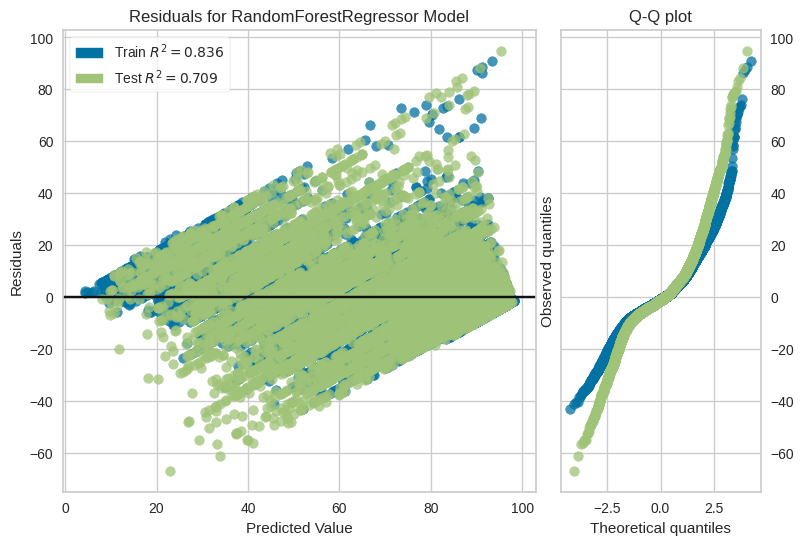

RMSE 10.483083629860651


Pipeline(steps=[('rf',
                 RandomForestRegressor(max_depth=13, max_features=0.8,
                                       n_estimators=800))])

In [21]:
pipe_rf = Pipeline(steps=[("rf", RandomForestRegressor(max_depth=13, max_features=0.8, n_estimators=800))])
make_residual_plot_and_print_rmse(Xtrain, ytrain, Xtest, ytest, pipe_rf)